In [0]:
import torchvision
import torch
data=torchvision.datasets.VOCSegmentation("/content/drive/My Drive/Colab Notebooks",'2012','trainval', False)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install Augmentor

In [0]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F  
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib
matplotlib.use('Agg')       
get_ipython().magic('matplotlib inline')
from matplotlib import pyplot    
from matplotlib.pyplot import subplot    
import sklearn.metrics as metrics 
from sklearn.metrics import accuracy_score
import PIL

In [0]:
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset

def load_image(file):
    return Image.open(file)

def image_path(root, basename, extension):
    return os.path.join(root, f'{basename}{extension}')

class VOC12(Dataset):

    def __init__(self, split, input_transform=None, target_transform=None):
        self.root='/content/drive/My Drive/Colab Notebooks/VOCdevkit/VOC2012'
        self.file_list = os.path.join(self.root, "ImageSets/Segmentation", split + ".txt")
        self.filenames = [line.rstrip() for line in list(open(self.file_list, "r"))]

        self.images_root = os.path.join(self.root, 'JPEGImages')
        self.labels_root = os.path.join(self.root, 'SegmentationClass')

        self.filenames.sort()

        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        filename = self.filenames[index]

        with open(image_path(self.images_root, filename, '.jpg'), 'rb') as f:
            image = load_image(f).convert('RGB')
        with open(image_path(self.labels_root, filename, '.png'), 'rb') as f:
            label = load_image(f).convert('P')

        if self.input_transform is not None:
            image = self.input_transform(image)
        if self.target_transform is not None:
            label = self.target_transform(label)

        return image, label

    def __len__(self):
        return len(self.filenames)

In [0]:
import numpy as np
import torch

from PIL import Image

def colormap(n):
    cmap=np.zeros([n, 3]).astype(np.uint8)

    for i in np.arange(n):
        r, g, b = np.zeros(3)

        for j in np.arange(8):
            r = r + (1<<(7-j))*((i&(1<<(3*j))) >> (3*j))
            g = g + (1<<(7-j))*((i&(1<<(3*j+1))) >> (3*j+1))
            b = b + (1<<(7-j))*((i&(1<<(3*j+2))) >> (3*j+2))

        cmap[i,:] = np.array([r, g, b])

    return cmap

class Relabel:

    def __init__(self, olabel, nlabel):
        self.olabel = olabel
        self.nlabel = nlabel

    def __call__(self, tensor):
        #img_np = np.array(tensor)
        #img_np[img_np == 255] = 0
        #assert isinstance(tensor, torch.LongTensor), 'tensor needs to be LongTensor'
        tensor[tensor == self.olabel] = self.nlabel
        #tensor=torch.tensor(img_np)
        return tensor


class ToLabel:

    def __call__(self, image):
        return torch.from_numpy(np.array(image)).long().unsqueeze(0)


class Colorize:

    def __init__(self, n=21):
        self.cmap = colormap(256)
        self.cmap[n] = self.cmap[-1]
        self.cmap = torch.from_numpy(self.cmap[:n])

    def __call__(self, gray_image):
        size = gray_image.size()
        color_image = torch.ByteTensor(3, size[1], size[2]).fill_(0)

        for label in range(1, len(self.cmap)):
            mask = gray_image[0] == label

            color_image[0][mask] = self.cmap[label][0]
            color_image[1][mask] = self.cmap[label][1]
            color_image[2][mask] = self.cmap[label][2]

        return color_image
from torchvision.transforms import Compose, CenterCrop, Normalize
from torchvision.transforms import ToTensor, ToPILImage
NUM_CHANNELS = 3
NUM_CLASSES = 21

color_transform = Colorize()
image_transform = ToPILImage()
input_transform = Compose([
    #CenterCrop((300,500)),
    transforms.Resize((256,256)),                        
    ToTensor(),
    #Normalize([.485, .456, .406], [.229, .224, .225]),
])
target_transform = Compose([
      #CenterCrop((300,500)),
      transforms.Resize((256,256)),
      ToLabel(),
      Relabel(255, 0),
])



In [0]:
voc =VOC12('train',input_transform, target_transform)
valid=VOC12('val',input_transform, target_transform)
loader = torch.utils.data.DataLoader(voc,
        num_workers=10, batch_size=5, shuffle=True)

train_loader = torch.utils.data.DataLoader(voc,
        num_workers=10, batch_size=1, shuffle=False)

valid_loader = torch.utils.data.DataLoader(valid,
        num_workers=10, batch_size=1, shuffle=False)



In [0]:
for img,lbl in loader:
  print(img.shape)

In [0]:
root='/content/drive/My Drive/Colab Notebooks/VOCdevkit/VOC2012'
file_list = os.path.join(root, "ImageSets/Segmentation", "train" + ".txt")
files = [line.rstrip('\n') for line in open(file_list)]
image_dir = os.path.join(root, 'JPEGImages')
label_dir = os.path.join(root, 'SegmentationClass')
files.sort()
#file_list = [line for  line.readline in open(file_list, "r")]
#files= list(zip(*file_list))
len(files)
print(len(files))
image_id = files[0]
image_path = os.path.join(image_dir, image_id + '.jpg')
label_path = os.path.join(label_dir, image_id + '.png')
print(image_path, label_path)
#filename = self.filenames[index]

#with open(image_path, 'rb') as f:
image = load_image(image_path)
#with open(label_path, 'rb') as f:
label = load_image(label_path)

if input_transform is not None:
    image = input_transform(image)
if target_transform is not None:
    label = target_transform(label)

print(label)
label=label.numpy()
label.resize((256,256))
img=label_to_color_image(label)
pyplot.imshow(img)

In [0]:
for img,lbl in loader:
  #print(img.shape, lbl.shape)
  #print(predicted_val.shape)
  print(lbl[0])
  lbl=lbl[0].numpy()
  lbl.resize((256,256))
  img=label_to_color_image(lbl)
  pyplot.imshow(img)
  break
  '''grid_img = torchvision.utils.make_grid(img, nrow=1)
  pyplot.imshow(grid_img.permute(1, 2, 0))'''
  

In [0]:
def printLabeledImage(lbl):
  lbl=lbl.numpy()
  lbl.resize((256,256))
  img=label_to_color_image(lbl)
  pyplot.imshow(img)

def printLabeledImageCPU(lbl):
  lbl=lbl.cpu().numpy()
  lbl.resize((256,256))
  img=label_to_color_image(lbl)
  pyplot.imshow(img)
  

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

from torch.utils import model_zoo
from torchvision import models

class FCN8(nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        feats = list(models.vgg16(pretrained=True).features.children())

        self.feats = nn.Sequential(*feats[0:9])
        self.feat3 = nn.Sequential(*feats[10:16])
        self.feat4 = nn.Sequential(*feats[17:23])
        self.feat5 = nn.Sequential(*feats[24:30])

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.requires_grad = False

        self.fconn = nn.Sequential(
            nn.Conv2d(512, 4096, 7),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Conv2d(4096, 4096, 1),
            nn.ReLU(inplace=True),
            nn.Dropout(),
        )
        self.score_feat3 = nn.Conv2d(256, num_classes, 1)
        self.score_feat4 = nn.Conv2d(512, num_classes, 1)
        self.score_fconn = nn.Conv2d(4096, num_classes, 1)

    def forward(self, x):
        feats = self.feats(x)
        feat3 = self.feat3(feats)
        feat4 = self.feat4(feat3)
        feat5 = self.feat5(feat4)
        fconn = self.fconn(feat5)

        score_feat3 = self.score_feat3(feat3)
        score_feat4 = self.score_feat4(feat4)
        score_fconn = self.score_fconn(fconn)

        score = F.upsample_bilinear(score_fconn, score_feat4.size()[2:])
        score += score_feat4
        score = F.upsample_bilinear(score, score_feat3.size()[2:])
        score += score_feat3

        return F.upsample_bilinear(score, x.size()[2:])


class FCN16(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        vgg_features=models.vgg16(pretrained=True).features;
        feats = list(vgg_features.children())
        self.feats = nn.Sequential(*feats[0:16])
        self.feat4 = nn.Sequential(*feats[17:23])
        self.feat5 = nn.Sequential(*feats[24:30])
        self.fconn = nn.Sequential(
            nn.Conv2d(512, 4096, 7),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Conv2d(4096, 4096, 1),
            nn.ReLU(inplace=True),
            nn.Dropout(),
        )
        self.score_fconn = nn.Conv2d(4096, num_classes, 1)
        self.score_feat4 = nn.Conv2d(512, num_classes, 1)

    def forward(self, x):
        feats = self.feats(x)
        feat4 = self.feat4(feats)
        feat5 = self.feat5(feat4)
        fconn = self.fconn(feat5)

        score_feat4 = self.score_feat4(feat4)
        score_fconn = self.score_fconn(fconn)

        score = F.upsample_bilinear(score_fconn, score_feat4.size()[2:])
        score += score_feat4

        return F.upsample_bilinear(score, x.size()[2:])


class FCN32(nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        self.feats = models.vgg16(pretrained=True).features
        for feature in self.feats:
            feature.requires_grad=False
        self.fconn = nn.Sequential(
            nn.Conv2d(512, 4096, 7),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Conv2d(4096, 4096, 1),
            nn.ReLU(inplace=True),
            nn.Dropout(),
        )
        self.score = nn.Conv2d(4096, num_classes, 1)
        self.upscore = nn.ConvTranspose2d(num_classes, num_classes, 224, stride=32,
                                          bias=False)

    def forward(self, x):
        feats = self.feats(x)
        fconn = self.fconn(feats)
        score = self.score(fconn)


        return self.upscore(score)



In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossEntropyLoss2d(nn.Module):

    def __init__(self, weight=None):
        super().__init__()

        self.loss = nn.NLLLoss2d(weight)

    def forward(self, outputs, targets):
        return self.loss(F.log_softmax(outputs,dim=1), targets)

In [0]:
vgg_net=torchvision.models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:22<00:00, 24.7MB/s]


In [0]:
import os.path as osp

import numpy as np
import torch
import torch.nn as nn


# https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/surgery.py
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()


class FCN16s(nn.Module):

    def __init__(self, n_class=21):
        super(FCN16s, self).__init__()
        # conv1
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2

        # conv2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/8

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/16

        # conv5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/32

        self.adapLayer = nn.AdaptiveAvgPool2d(output_size=(7, 7))

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

       # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.score_pool4 = nn.Conv2d(512, n_class, 1)

        self.upscore2 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
        self.upscore16 = nn.ConvTranspose2d(
            n_class, n_class, 32, stride=16, bias=False)

        #self._initialize_weights()
        #self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        h = x
        h = self.relu1_1(self.conv1_1(h))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)
        #print('pool 4',h.shape)
        pool4 = h
           
        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)
        
        #print('pool 5',h.shape)

        #h=self.adapLayer(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        #print('pool 6',h.shape)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        #print('pool 7',h.shape)

        h = self.score_fr(h)
        h = self.upscore2(h)
        upscore2 = h  # 1/16

        #print('upscore on 7',h.shape)
        h = self.score_pool4(pool4)
        #print('upscore on 4',h.shape)
        h=F.upsample_bilinear(h, upscore2.size()[2:])
        #h = h[:, :, 5:5 + upscore2.size()[2], 5:5 + upscore2.size()[3]]
        score_pool4c = h  # 1/16
        #print('updation on size of 4',h.shape)
        h = upscore2 + score_pool4c

        h = self.upscore16(h)
        h=F.upsample_bilinear(h, x.size()[2:])
        #print('final stride on output', h.shape)
        #h = h[:, :, 27:27 + x.size()[2], 27:27 + x.size()[3]].contiguous()

        #print('final result',h.shape) 
        return h

    def copy_params_from_fcn32s(self, fcn32s):
        for name, l1 in fcn32s.named_children():
            try:
                l2 = getattr(self, name)
                l2.weight  # skip ReLU / Dropout
            except Exception:
                continue
            assert l1.weight.size() == l2.weight.size()
            assert l1.bias.size() == l2.bias.size()
            l2.weight.data.copy_(l1.weight.data)
            l2.bias.data.copy_(l1.bias.data)
            l2.weight.requires_grad=True
            l2.bias.requires_grad=True

    def copy_params_from_vgg16(self, vgg16):
      features = [
          self.conv1_1, self.relu1_1,
          self.conv1_2, self.relu1_2,
          self.pool1,
          self.conv2_1, self.relu2_1,
          self.conv2_2, self.relu2_2,
          self.pool2,
          self.conv3_1, self.relu3_1,
          self.conv3_2, self.relu3_2,
          self.conv3_3, self.relu3_3,
          self.pool3,
          self.conv4_1, self.relu4_1,
          self.conv4_2, self.relu4_2,
          self.conv4_3, self.relu4_3,
          self.pool4,
          self.conv5_1, self.relu5_1,
          self.conv5_2, self.relu5_2,
          self.conv5_3, self.relu5_3,
          self.pool5,
      ]
      for l1, l2 in zip(vgg16.features, features):
          if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
              assert l1.weight.size() == l2.weight.size()
              assert l1.bias.size() == l2.bias.size()
              l2.weight.data = l1.weight.data
              l2.bias.data = l1.bias.data
              #l2.weight.requires_grad = True
              #l2.bias.requires_grad = False
                
                

In [0]:
import os.path as osp

import numpy as np
import torch
import torch.nn as nn


# https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/surgery.py
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()


class FCN32s(nn.Module):

    def __init__(self, n_class=21):
        super(FCN32s, self).__init__()
        # conv1
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2

        # conv2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/8
        

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/16

        # conv5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/32

        #self.adapLayer = nn.AdaptiveAvgPool2d(output_size=(7, 7))

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.upscore = nn.ConvTranspose2d(n_class, n_class, 64, stride=32,
                                          bias=False)

        #self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        h = x
        h = self.relu1_1(self.conv1_1(h))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        #h=self.adapLayer(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        h = self.score_fr(h)

        h = self.upscore(h)
        #print(h.shape)
        #h=F.interpolate(h, x.size()[2:], mode=)
        h=F.upsample_bilinear(h, (x.size()[2], x.size()[3]))
        #print(h.size())
        #h = h[:, :, 19:19 + x.size()[2], 19:19 + x.size()[3]].contiguous()
        return h

    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
                l2.weight.requires_grad = False
                l2.bias.requires_grad = False
        
                
                

In [0]:
FCN16=FCN16s(21)
#FCN16.copy_params_from_vgg16(vgg_net)
FCN16.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/modefcn16"))

<All keys matched successfully>

In [0]:
FCN32 = FCN32s(21)
#FCN32.copy_params_from_vgg16(vgg_net)
FCN32.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/modefcn32"))

<All keys matched successfully>

True


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:210: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see https://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2577: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


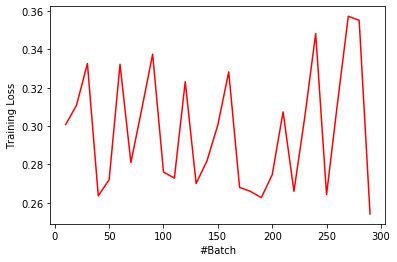

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Training:::for epoch 0 IOU is: 0.5862548323368522
Training:::for epoch 0 Dice is: 0.44399079088095883


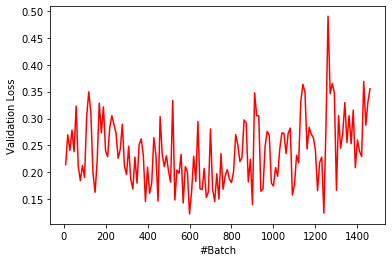

Validation:::for epoch 0 IOU is: 0.40528414922703837
Validation:::for epoch 0 Dice is: 0.3262642160206483


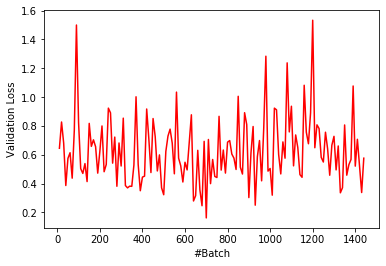

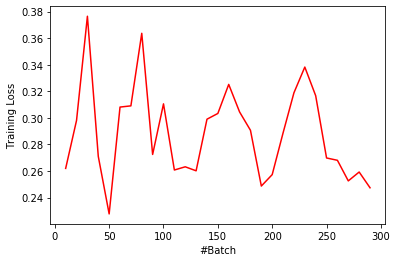

Training:::for epoch 1 IOU is: 0.5862548323368522
Training:::for epoch 1 Dice is: 0.44399079088095883


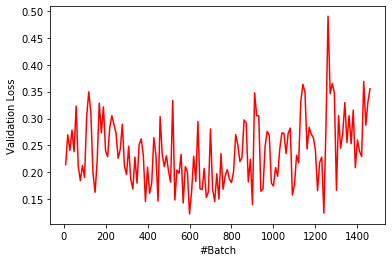

Validation:::for epoch 1 IOU is: 0.40528414933338497
Validation:::for epoch 1 Dice is: 0.32626421588446913


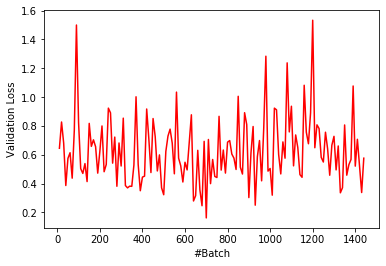

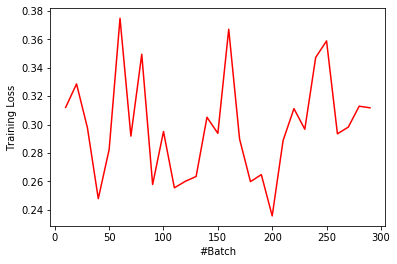

Training:::for epoch 2 IOU is: 0.5862548323368522
Training:::for epoch 2 Dice is: 0.44399079088095883


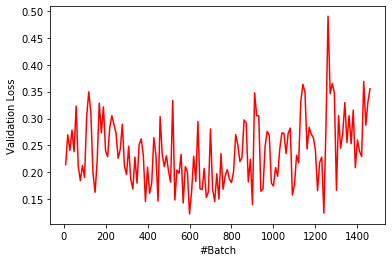

Validation:::for epoch 2 IOU is: 0.40528414922703837
Validation:::for epoch 2 Dice is: 0.3262642160206483


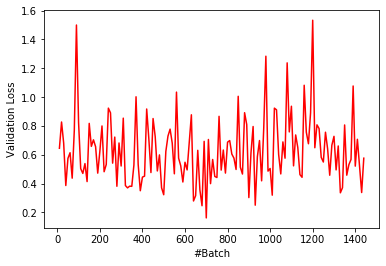

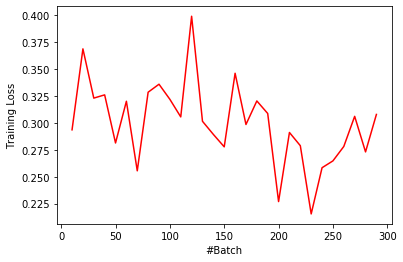

Training:::for epoch 3 IOU is: 0.5862548460496176
Training:::for epoch 3 Dice is: 0.44399080454229783


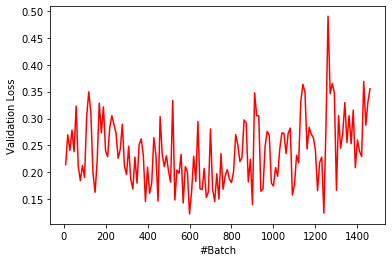

Validation:::for epoch 3 IOU is: 0.40528414922703837
Validation:::for epoch 3 Dice is: 0.3262642160206483


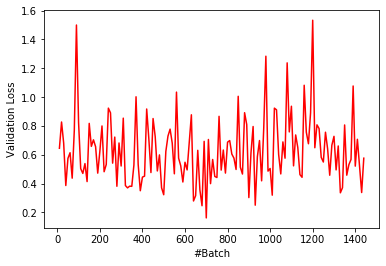

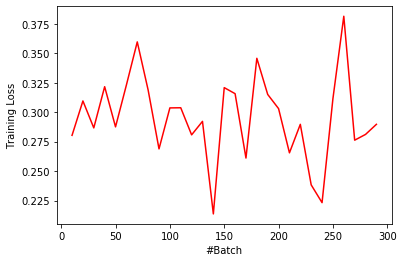

Training:::for epoch 4 IOU is: 0.5862548460496176
Training:::for epoch 4 Dice is: 0.44399080454229783


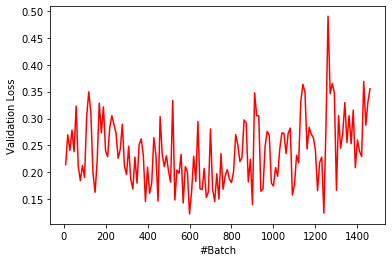

Validation:::for epoch 4 IOU is: 0.40528414933338497
Validation:::for epoch 4 Dice is: 0.32626421588446913


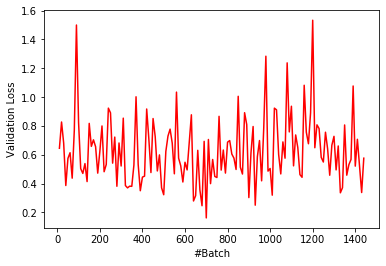

In [0]:
CUDA_LAUNCH_BLOCKING=1
print(torch.cuda.is_available())
FCN32=FCN32.cuda()
max_epochs=5
weight = torch.ones(21)
weight[0] = 0
#criterion = CrossEntropyLoss2d(weight.cuda())
criterion = CrossEntropyLoss2d()
learning_rate=0.001
momentum = 0.99
optimizer = optim.Adam(FCN32.parameters(), lr=learning_rate)

#optimizer = optim.SGD(FCN16.parameters(), lr=1.0e-5, momentum=0.99)
training_accuracy=[]
validation_accuracy=[]
prev_accuracy=0.0

curr_accuracy=0.0
epoch_count=0
IOU=0
for epoch in range(max_epochs):
    epoch_count+=1
    # Training
    #print(epoch)
    loss_list=[]
    num_batch_list=[]
    num_batches=0
    final_loss=[]
    FCN32.train()
    for local_batch, local_labels in loader:
      # Transfer to GPU
      #imshow(torchvision.utils.make_grid(local_batch))
      #print(local_labels.shape, local_batch.shape)
      optimizer.zero_grad()
      local_batch, local_labels =  torch.autograd.Variable(local_batch.cuda()), torch.autograd.Variable(local_labels.cuda())     
      #pyplot.imshow(PIL.Image.open(local_labels[0]))
      output = FCN32(local_batch)
      #print(output.shape, local_labels.shape, local_batch.shape)
      #output =torch.nn.functional.log_softmax(output,dim=1)
      #output =torch.argmax(output,dim=1)
      #print(output.shape)
      #print(output.shape)
      #print(local_labels[:,0].shape, output.shape)
      loss = criterion(output, local_labels[:,0])
      #loss = criterion(output, local_labels)
      #print(loss.item())
      loss_list.append(loss.item())
      loss.backward()
      '''for param in FCN16.parameters():
        print(param.grad.data.sum())'''
      optimizer.step()
      num_batches+=1
      if num_batches % 10 == 0:
            num_batch_list.append(num_batches)
            final_loss.append(np.mean(loss_list))
            loss_list.clear()
    # plotting training and validation accuracies
    fig2 = pyplot.figure()
    pyplot.plot(num_batch_list, final_loss, 'r')
    pyplot.xlabel("#Batch")
    pyplot.ylabel("Training Loss") 
    pyplot.show(fig2) 

    
    FCN32.eval()
    IOU=0
    Dice=0
    num_batches=0
    loss_list=[]
    num_batch_list=[]
    final_loss=[]

    for local_batch, local_labels in train_loader:
      #print(local_batch.size())
      # Transfer to GPU
      local_batch=  torch.autograd.Variable(local_batch.cuda())
      local_labels=  torch.autograd.Variable(local_labels.cuda())
      # Model computations
      predicted_val = FCN32(local_batch)
      loss = criterion(predicted_val, local_labels[:,0])
      #print(predicted_val[0], local_labels[0])
      predicted_val=nn.functional.log_softmax(predicted_val, dim=1)
      #print(predicted_val.shape, local_labels.shape)
      predicted_val=torch.argmax(predicted_val, dim=1)
      #print("printing predicted image")
      #printLabeledImageCPU(predicted_val[0])
      #print("printing predicted image")
      #printLabeledImageCPU(local_labels[0])
      #print(predicted_val.shape, local_labels.shape)
      predicted_val = predicted_val.cpu().data.numpy()
      loss_list.append(loss.item())
      num_batches+=1
      if num_batches % 10 == 0:
            num_batch_list.append(num_batches)
            final_loss.append(np.mean(loss_list))
            loss_list.clear()
            # plotting training and validation accuracies

      #print(predicted_val.shape, local_labels.shape)
      currentIou, currentDice=compute_iou(predicted_val, local_labels.cpu().numpy()) 
      #print(currentIou, currentDice, IOU, Dice)
      IOU=IOU+currentIou
      Dice=Dice+currentDice
      #print("accuracy for batch ", num_batches,accuracy)
      training_accuracy.append(IOU/num_batches)  
    print("Training:::for epoch", epoch, "IOU is:",IOU/num_batches)
    print("Training:::for epoch", epoch, "Dice is:",Dice/num_batches)
    fig2 = pyplot.figure()
    pyplot.plot(num_batch_list, final_loss, 'r')
    pyplot.xlabel("#Batch")
    pyplot.ylabel("Validation Loss") 
    pyplot.show(fig2) 
    
    FCN32.eval()
    IOU=0
    Dice=0
    num_batches=0
    loss_list=[]
    num_batch_list=[]
    final_loss=[]
    for local_batch, local_labels in valid_loader:
      # Transfer to GPU
      local_batch=  torch.autograd.Variable(local_batch.cuda())
      local_labels=  torch.autograd.Variable(local_labels.cuda())
      # Model computations
      predicted_val = FCN32(local_batch)
      loss = criterion(predicted_val, local_labels[:,0])
      predicted_val=nn.functional.log_softmax(predicted_val, dim=1)
      #print(predicted_val.shape, local_labels.shape)
      predicted_val=torch.argmax(predicted_val, dim=1)
      #print(predicted_val.shape, local_labels.shape)
      predicted_val = predicted_val.cpu().data.numpy()
      loss_list.append(loss.item())
      num_batches+=1
      if num_batches % 10 == 0:
            num_batch_list.append(num_batches)
            final_loss.append(np.mean(loss_list))
            loss_list.clear()
            # plotting training and validation accuracies

      #print(predicted_val.shape, local_labels.shape)
      currentIou, currentDice=compute_iou(predicted_val, local_labels.cpu().numpy()) 
      #print(currentIou, currentDice, IOU, Dice)
      IOU=IOU+currentIou
      Dice=Dice+currentDice
      #print("accuracy for batch ", num_batches,accuracy)
      training_accuracy.append(IOU/num_batches)  
    print("Validation:::for epoch", epoch, "IOU is:",IOU/num_batches)
    print("Validation:::for epoch", epoch, "Dice is:",Dice/num_batches)
    fig2 = pyplot.figure()
    pyplot.plot(num_batch_list, final_loss, 'r')
    pyplot.xlabel("#Batch")
    pyplot.ylabel("Validation Loss") 
    pyplot.show(fig2) 


In [0]:
FCN16.cuda()
FCN16.eval()
IOU=np.zeros(21)
Dice=np.zeros(21)
num_batches=0
loss_list=[]
num_batch_list=[]
final_loss=[]
available_class=np.zeros(21)
for local_batch, local_labels in valid_loader:
  # Transfer to GPU
  local_batch=  torch.autograd.Variable(local_batch.cuda())
  local_labels=  torch.autograd.Variable(local_labels.cuda())
  # Model computations
  predicted_val = FCN16(local_batch)
  predicted_val=nn.functional.log_softmax(predicted_val, dim=1)
  #print(predicted_val.shape, local_labels.shape)
  predicted_val=torch.argmax(predicted_val, dim=1)
  #print(predicted_val.shape, local_labels.shape)
  predicted_val = predicted_val.cpu().data.numpy()
  #print(predicted_val.shape, local_labels.shape)
  currentIou, currentDice=compute_iou_each_class(predicted_val, local_labels.cpu().numpy()) 
  #print(currentIou, currentDice, IOU, Dice)
  IOU=(IOU+currentIou)
  available_class+=[1 if x > 0 else 0 for x in currentIou]
  Dice=Dice+currentDice


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2577: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [0]:
output=IOU/(available_class-1)
[ '%.2f' % elem for elem in output ]
output=Dice/available_class
#[  i for i in range(21)]
count=0
for x in output:
    print('class',count,':','%.2f' %x)
    count+=1

NameError: ignored

In [0]:
torch.save(FCN32.state_dict(), "/content/drive/My Drive/Colab Notebooks/modefcn32_320")

In [0]:
torch.save(FCN16.state_dict(), "/content/drive/My Drive/Colab Notebooks/modefcn16")

In [0]:
printLabeledImageCPU(predicted_val_final[0])

In [0]:
printLabeledImageCPU(local_labels[0])

In [0]:
for img, label in valid_loader:
  print(predicted_val.shape)
  label=label.numpy()
  local_labels.resize((256,256))
  img=label_to_color_image(local_labels)

(500, 500)


In [0]:
trans=transforms.ToPILImage()
local_batch=local_batch.cpu().numpy()
local_batch.resize((3,500,500))
pyplot.imshow(trans(local_batch))

In [0]:
predicted_val

array([[15, 15, 15, ..., 15, 15, 15],
       [15, 15, 15, ..., 15, 15, 15],
       [15, 15, 15, ..., 15, 15, 15],
       ...,
       [15, 15, 15, ..., 15, 15, 15],
       [15, 15, 15, ..., 15, 15, 15],
       [15, 15, 15, ..., 15, 15, 15]])

In [0]:
# Dataset names.
_ADE20K = 'ade20k'
_CITYSCAPES = 'cityscapes'
_MAPILLARY_VISTAS = 'mapillary_vistas'
_PASCAL = 'pascal'

_DATASET_MAX_ENTRIES = {
    _ADE20K: 151,
    _CITYSCAPES: 256,
    _MAPILLARY_VISTAS: 66,
    _PASCAL: 512,
}

def bit_get(val, idx):
  """Gets the bit value.
  Args:
    val: Input value, int or numpy int array.
    idx: Which bit of the input val.
  Returns:
    The "idx"-th bit of input val.
  """
  return (val >> idx) & 1

def label_to_color_image(label, dataset=_PASCAL):
  """Adds color defined by the dataset colormap to the label.
  Args:
    label: A 2D array with integer type, storing the segmentation label.
    dataset: The colormap used in the dataset.
  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the dataset color map.
  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """

  if label.ndim != 2:
    raise ValueError('Expect 2-D input label. Got {}'.format(label.shape))

  if np.max(label) >= _DATASET_MAX_ENTRIES[dataset]:
    raise ValueError(
        'label value too large: {} >= {}.'.format(
            np.max(label), _DATASET_MAX_ENTRIES[dataset]))

  colormap = create_label_colormap(dataset)
  return colormap[label]

def create_label_colormap(dataset=_PASCAL):
  """Creates a label colormap for the specified dataset.
  Args:
    dataset: The colormap used in the dataset.
  Returns:
    A numpy array of the dataset colormap.
  Raises:
    ValueError: If the dataset is not supported.
  """
  return create_pascal_label_colormap()

def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.
  Returns:
    A colormap for visualizing segmentation results.
  """
  colormap = np.zeros((_DATASET_MAX_ENTRIES[_PASCAL], 3), dtype=int)
  ind = np.arange(_DATASET_MAX_ENTRIES[_PASCAL], dtype=int)

  for shift in reversed(list(range(8))):
    for channel in range(3):
      colormap[:, channel] |= bit_get(ind, channel) << shift
    ind >>= 3

  return colormap


In [0]:
from sklearn.metrics import confusion_matrix  
import numpy as np

def compute_iou(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=list(range(0, 21)))
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    dice = np.nan_to_num(np.divide(2*intersection,(ground_truth_set + predicted_set+intersection)))
    IoU = np.nan_to_num(np.divide(intersection , union.astype(np.float32)))
    #print(union, intersection, np.nonzero(union)[0])
    #return np.mean(IoU), np.mean(dice)
    return np.sum(IoU)/len(np.nonzero(union)[0]), np.sum(dice)/len(np.nonzero(union)[0])

In [0]:
from sklearn.metrics import confusion_matrix  
import numpy as np

def compute_iou_each_class(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=list(range(0, 21)))
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    dice = np.nan_to_num(np.divide(2*intersection,(ground_truth_set + predicted_set+intersection)))
    IoU = np.nan_to_num(np.divide(intersection , union.astype(np.float32)))
    #print(union, intersection, np.nonzero(union)[0])
    #return np.mean(IoU), np.mean(dice)
    return IoU, dice

In [0]:
y_pred=np.array([[1,2,0],[0,2,0]], dtype=np.float32)
y_true =np.array([[1,0,0],[0,2,0]], dtype=np.float32)
print(compute_iou_each_class(y_pred,y_true))

[4 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(array([0.25      , 0.33333333, 0.16666667, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ]), array([0.2       , 0.22222222, 0.16666667, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [0]:
data.images[1]

In [0]:
from DataLoader import VOCSegmentation
from util import decode_segmap
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

voc_train = VOCSegmentation(split='train')
print(len(voc_train))

dataloader = DataLoader(voc_train, batch_size=5, shuffle=True, num_workers=2)

for ii, sample in enumerate(dataloader):
    for jj in range(sample["image"].size()[0]):
        img = sample['image'].numpy()
        gt = sample['label'].numpy()
        tmp = np.array(gt[jj]).astype(np.uint8)
        segmap = decode_segmap(tmp, dataset='pascal')
        img_tmp = np.transpose(img[jj], axes=[1, 2, 0])
        img_tmp *= (0.229, 0.224, 0.225)
        img_tmp += (0.485, 0.456, 0.406)
        img_tmp *= 255.0
        img_tmp = img_tmp.astype(np.uint8)
        plt.figure()
        plt.title('display')
        plt.subplot(211)
        plt.imshow(img_tmp)
        plt.subplot(212)
        plt.imshow(segmap)

    if ii == 1:
        break

plt.show(block=True)

ModuleNotFoundError: ignored

In [0]:
root='/content/drive/My Drive/Colab Notebooks/VOCdevkit/VOC2012'
file_list = os.path.join(root, "ImageSets/Segmentation", 'val' + ".txt")
filenames = [line.rstrip() for line in list(open(file_list, "r"))]

images_root = os.path.join(root, 'JPEGImages')
labels_root = os.path.join(root, 'SegmentationClass')
filenames.sort()

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2577: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


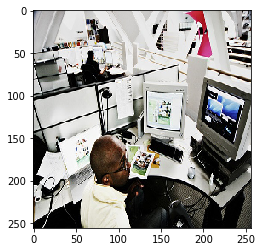

In [0]:
index=55
filename = filenames[index]

with open(image_path(images_root, filename, '.jpg'), 'rb') as f:
    org_image = load_image(f).convert('RGB')
with open(image_path(labels_root, filename, '.png'), 'rb') as f:
    org_label = load_image(f).convert('P')

if input_transform is not None:
    image = input_transform(org_image)
if target_transform is not None:
    label = target_transform(org_label)
model=FCN16
model.cuda()
model.eval()
print(image.shape)

image=image.unsqueeze(axis=0)
predicted_val=model(torch.autograd.Variable(image.cuda()))
predicted_val=nn.functional.log_softmax(predicted_val, dim=1)
#print(predicted_val.shape, local_labels.shape)
predicted_val=torch.argmax(predicted_val, dim=1)
predicted_label=predicted_val.cpu().numpy()
predicted_label=predicted_label.squeeze(axis=0)
print(label.shape)
label=label.squeeze(axis=0)
org_label=org_label.resize((256,256))
org_image=org_image.resize((256,256))
pyplot.imshow(org_image)
#pyplot.imshow(label_to_color_image(predicted_label))